In [1]:
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import grad
import matplotlib.pyplot as plt
import time
from logging import raiseExceptions
import tensorflow as tf

# Q1

In [2]:
def f_torch(x, standardDeviation = 0.2, mean = 0):
    sigma = np.sqrt(standardDeviation)
    mu = mean
    e = torch.exp( (- 1/(2* sigma**2) * (x-mu)**2)  )
    y = sigma * (np.sqrt((2/np.pi))) * e
    return y

def gradient_torch(y, x, grad_outputs=None, device = 'cpu'):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
        grad_outputs.to(device)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def exactGradient_torch(x, standardDeviation = 0.2, mean = 0, level = 1):
  sd = standardDeviation
  y = f_torch(x, sd, mean)

  if level ==1:
    out = -(x-mean)/sd * y
    return out

  elif level ==2:
    out = (-1/sd) * ( y -  ((x-mean)**2/sd) *y)
    return out

  elif level==3:
    t1 = ((x-mean)/sd**2)  * y
    t2 = (2 * (x-mean)/sd**2 ) *y
    t3 = - ((x-mean)**3 /sd**3 ) * y
    out = t1+t2+t3
    return out
  else :
    raiseExceptions(f'Cant find  {level} gradient')

In [3]:
def f_tf(x, standardDeviation = 0.2, mean = 0):
    sigma = np.sqrt(standardDeviation)
    mu = mean
    e = tf.exp( (- 1/(2* sigma**2) * (x-mu)**2)  )
    y = sigma * (np.sqrt((2/np.pi))) * e
    return y

def gradient_tf(y, x):

    with tf.GradientTape() as tape:
        tape.watch(x)
        y = f_tf(x)
    grad = tape.gradient(y, x)
    return grad

## Q1: CPU (PyTorch)

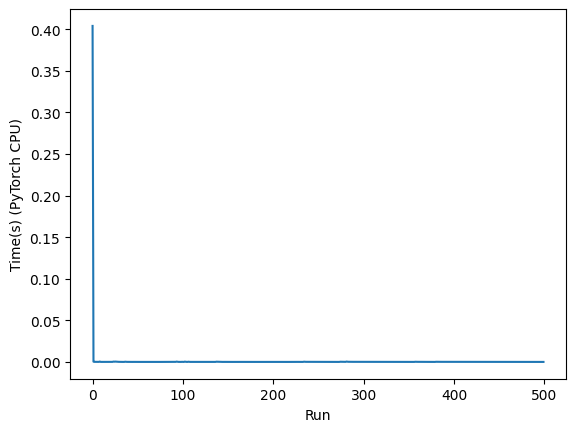

Mean run-time (s): 0.0009456019401550293
Standard deviation of run-times (s): 0.01804621140496745


In [4]:
device = torch.device('cpu')
n  = 10000
times = []
for _ in range(500):
    start_time = time.time()
    x = torch.linspace(-5, 5, n, device= device, dtype=torch.float32, requires_grad=True)
    y = f_torch(x)
    first_derivative_autograd = gradient_torch(y,x)
    times.append(time.time() - start_time)

plt.plot(times)
plt.xlabel('Run')
plt.ylabel('Time(s) (PyTorch CPU)')
plt.show()

print('Mean run-time (s):', np.mean(times))
print('Standard deviation of run-times (s):', np.std(times))


## Q1: GPU (PyTorch)

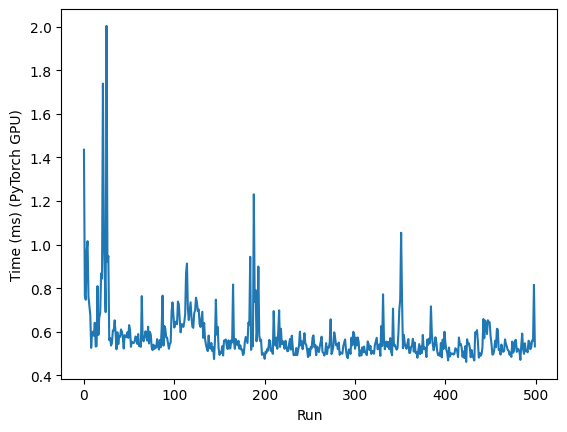

Mean run-time (s): 0.0005779303687810898
Standard deviation of run-times (s): 0.00013040503473421385


In [32]:
device = torch.device('cuda')
n  = 10000
times = []
for _ in range(500):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    x = torch.linspace(-5, 5, n, device= device, dtype=torch.float32, requires_grad=True)
    y = f_torch(x)
    first_derivative_autograd = gradient_torch(y,x, device=device)

    end.record()
    torch.cuda.synchronize()
    times.append(start.elapsed_time(end))

plt.plot(times)
plt.xlabel('Run')
plt.ylabel('Time (ms) (PyTorch GPU)')
plt.show()

print('Mean run-time (s):', np.mean(times)/1000)
print('Standard deviation of run-times (s):', np.std(times)/1000)


## Q1: CPU (Tensorflow)

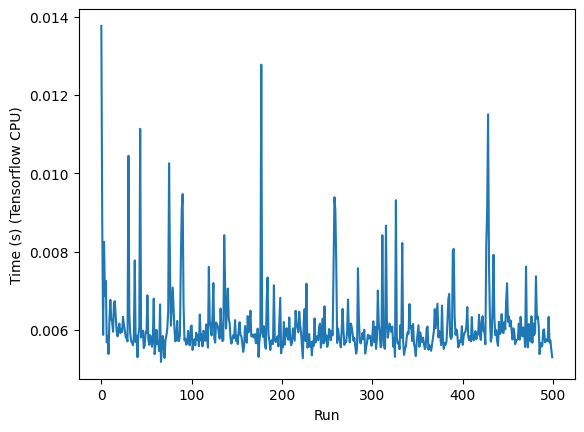

Mean run-time (s): 0.006110610008239746
Standard deviation of run-times (s): 0.000894009541729533


In [33]:
times = []
for _ in range(500):

    with tf.device('CPU:0'):
        start_time = time.time()
        x = tf.Variable(tf.linspace(-5.0, 5.0, 10000), dtype=tf.float32)
        dy_dx_tf = gradient_tf(y,x)
        times.append(time.time() - start_time)

plt.plot(times)
plt.xlabel('Run')
plt.ylabel('Time (s) (Tensorflow CPU)')
plt.show()

print('Mean run-time (s):', np.mean(times))
print('Standard deviation of run-times (s):', np.std(times))

## Q1: GPU (Tensorflow)

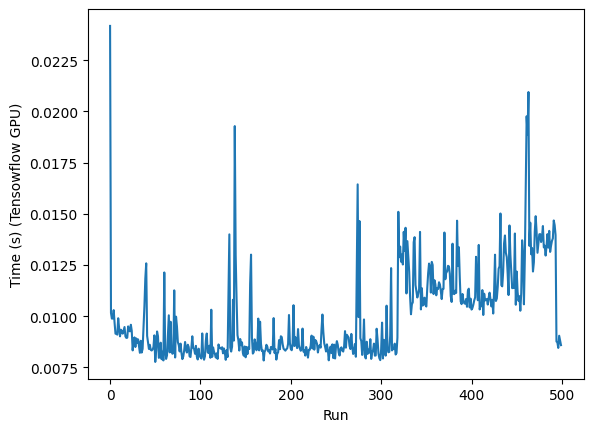

Mean run-time (s): 0.010040551662445068
Standard deviation of run-times (s): 0.0022254730417015484


In [34]:
times = []
for _ in range(500):
    with tf.device('GPU:0'):
        start_time = time.time()
        x = tf.Variable(tf.linspace(-5.0, 5.0, 10000), dtype=tf.float32)
        dy_dx_tf = gradient_tf(y,x)
        times.append(time.time() - start_time)

plt.plot(times)
plt.xlabel('Run')
plt.ylabel('Time (s) (Tensowflow GPU)')
plt.show()
print('Mean run-time (s):', np.mean(times))
print('Standard deviation of run-times (s):', np.std(times))

# Q2

In [35]:
!nvidia-smi

Mon Mar 11 19:45:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    125MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## f'(x)

### Q2: CPU

PyTorch CPU time (s): 0.0015892982482910156


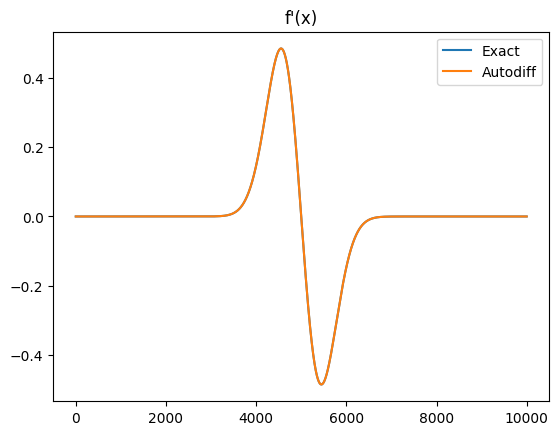

In [36]:
device = torch.device('cpu')
n  = 10000

#### --- PyTorch CPU --- ####
start_time = time.time()
x  =  torch.linspace(-5,5,n, device = device, dtype=torch.float32, requires_grad = True)
y = f_torch(x)
dy_dx = gradient_torch(y,x)
print('PyTorch CPU time (s):', time.time() - start_time)
dy_dx_exact = exactGradient_torch(x)

plt.plot(dy_dx.detach().cpu(), label = 'Exact')
plt.plot(dy_dx_exact.detach().cpu(), label = 'Autodiff')
plt.legend()
plt.title(f"f'(x)")
plt.show()

### Q2: GPU

PyTorch GPU time (s): 0.005109407901763916


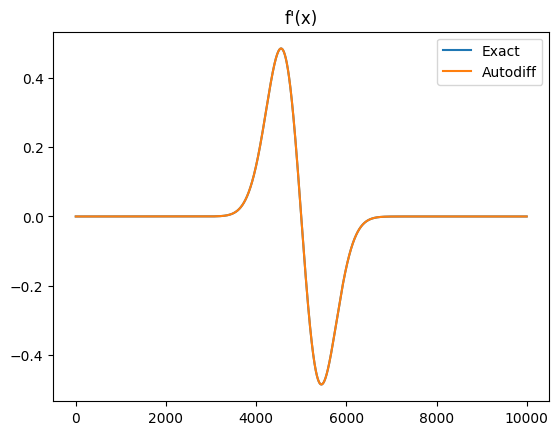

In [37]:
device = torch.device('cuda')
n  = 10000

#### --- PyTorch GPU --- ####
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
x  =  torch.linspace(-5.0,5.0,n, device = device, dtype=torch.float32, requires_grad = True)
y = f_torch(x)
dy_dx = gradient_torch(y,x, device=device)
end.record()
torch.cuda.synchronize()
print('PyTorch GPU time (s):', start.elapsed_time(end)/1000)

dy_dx_exact = exactGradient_torch(x)
plt.plot(dy_dx.detach().cpu(), label = 'Exact')
plt.plot(dy_dx_exact.detach().cpu(), label = 'Autodiff')
plt.legend()
plt.title(f"f'(x)")
plt.show()

## f''(x)

### Q2: CPU

PyTorch CPU time (s): 0.002602100372314453


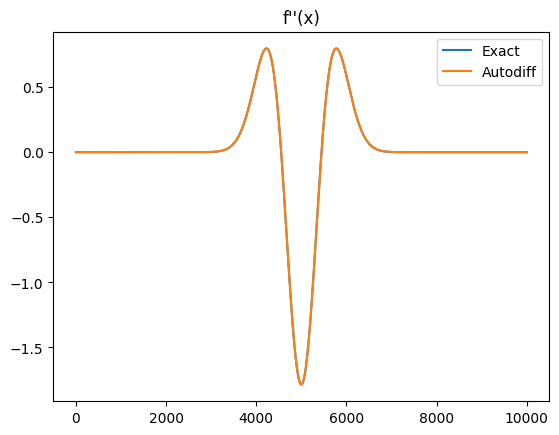

In [5]:
device = torch.device('cpu')
n  = 10000

#### --- PyTorch CPU --- ####
start_time = time.time()
x  =  torch.linspace(-5.0,5.0,n, device = device, dtype=torch.float32, requires_grad = True)
y = f_torch(x)
dy_dx = gradient_torch(y,x)
dy_dx_dx = gradient_torch(dy_dx,x)
dy_dx_dx_exact = exactGradient_torch(x, level=2)
print('PyTorch CPU time (s):', time.time() - start_time)


plt.plot(dy_dx_dx.detach().cpu(), label = 'Exact')
plt.plot(dy_dx_dx_exact.detach().cpu(), label = 'Autodiff')
plt.legend()
plt.title(f"f''(x)")
plt.show()

### Q2: GPU

In [39]:
device = torch.device('cuda')
n  = 10000

#### --- PyTorch GPU --- ####
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
x  =  torch.linspace(-5.0,5.0,n, device = device, dtype=torch.float32, requires_grad = True)
y = f_torch(x)
dy_dx = gradient_torch(y,x, device=device)
dy_dx_dx = gradient_torch(dy_dx,x, device=device)
dy_dx_dx_exact = exactGradient_torch(x, level=2)
end.record()
torch.cuda.synchronize()

print('PyTorch GPU time (s):', start.elapsed_time(end)/1000)

PyTorch GPU time (s): 0.002643199920654297


# Q3

## f'''(x)

### Q3: CPU

PyTorch CPU time (s): 0.004628896713256836


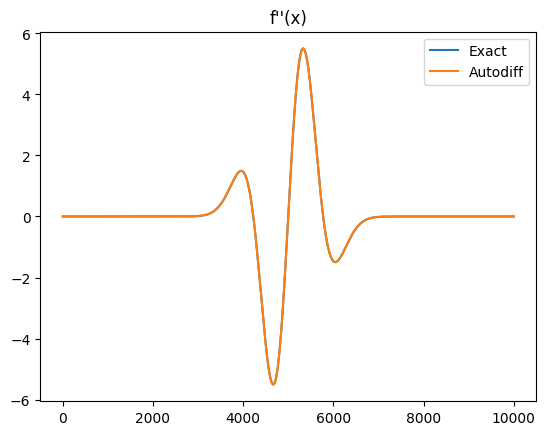

In [42]:
device = torch.device('cpu')
n  = 10000

#### --- PyTorch CPU --- ####
start_time = time.time()
x  =  torch.linspace(-5.0,5.0,n, device = device, dtype=torch.float32, requires_grad = True)
y = f_torch(x)
dy_dx = gradient_torch(y,x)
dy_dx_dx = gradient_torch(dy_dx,x)
dy_dx_dx_dx = gradient_torch(dy_dx_dx,x)
dy_dx_dx_dx_exact = exactGradient_torch(x, level=3)
print('PyTorch CPU time (s):', time.time() - start_time)

plt.plot(dy_dx_dx_dx.detach().cpu(), label = 'Exact')
plt.plot(dy_dx_dx_dx_exact.detach().cpu(), label = 'Autodiff')
plt.legend()
plt.title(f"f''(x)")
plt.show()

### Q3: GPU

In [43]:
device = torch.device('cuda')
n  = 10000

#### --- PyTorch GPU --- ####
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
x  =  torch.linspace(-5,5,n, device = device, dtype=torch.float32, requires_grad = True)
y = f_torch(x)
dy_dx = gradient_torch(y,x, device=device)
dy_dx_dx = gradient_torch(dy_dx,x, device=device)
dy_dx_dx_dx = gradient_torch(dy_dx_dx,x, device=device)
dy_dx_dx_dx_exact = exactGradient_torch(x, level=3)
end.record()
torch.cuda.synchronize()

print('PyTorch GPU time (s):', start.elapsed_time(end)/1000)

PyTorch GPU time (s): 0.005111807823181152


# Q4

## Q4: CPU

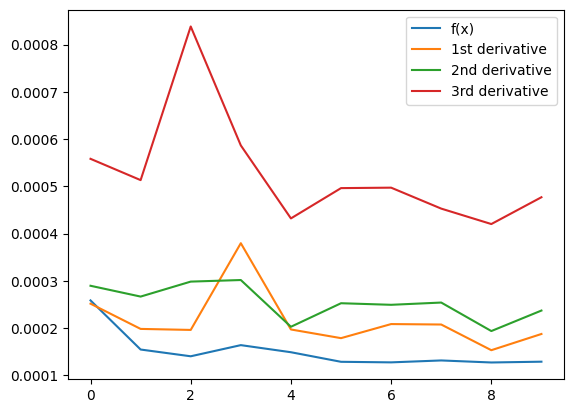

In [44]:
runtime_0 =[]
runtime_1 =[]
runtime_2 =[]
runtime_3 =[]

device = torch.device('cpu')
n  = 10000
x  =  torch.linspace(-5.0,5.0,n, device = device, dtype=torch.float32, requires_grad = True)

for i in range(10):
  #f(x)
  t1 = time.time()
  y = f_torch(x)
  t2 = time.time()
  runtime_0 += [t2-t1]

  #1st derivative
  t1 = time.time()
  derivative = gradient_torch(y,x)
  t2 = time.time()
  runtime_1 += [t2-t1]

  #2nd derivative
  t1 = time.time()
  derivative = gradient_torch(derivative,x)
  t2 = time.time()
  runtime_2 += [t2-t1]

  #3rd derivative
  t1 = time.time()
  derivative = gradient_torch(derivative,x)
  t2 = time.time()
  runtime_3 += [t2-t1]

plt.plot(runtime_0, label = 'f(x)')
plt.plot(runtime_1, label = '1st derivative')
plt.plot(runtime_2,label = '2nd derivative')
plt.plot(runtime_3,label = '3rd derivative')
plt.legend()
plt.show()

## Q4: GPU

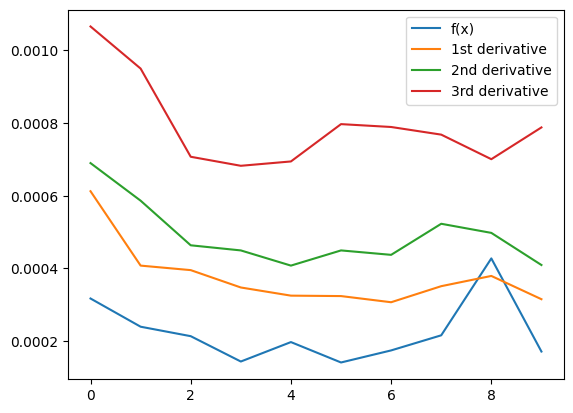

In [45]:
runtime_0 =[]
runtime_1 =[]
runtime_2 =[]
runtime_3 =[]

device = torch.device('cuda')
n  = 10000
x  =  torch.linspace(-5.0,5.0,n, device = device, dtype=torch.float32, requires_grad = True)

for i in range(10):
  #zeroth
  t1 = time.time()
  y = f_torch(x)
  t2 = time.time()
  runtime_0 += [t2-t1]

  #ist derivative
  t1 = time.time()
  derivative = gradient_torch(y,x, device=device)
  t2 = time.time()
  runtime_1 += [t2-t1]

  #2nd derivative
  t1 = time.time()
  derivative = gradient_torch(derivative,x, device=device)
  t2 = time.time()
  runtime_2 += [t2-t1]

  #3rd derivative
  t1 = time.time()
  derivative = gradient_torch(derivative,x, device=device)
  t2 = time.time()
  runtime_3 += [t2-t1]

plt.plot(runtime_0, label = 'f(x)')
plt.plot(runtime_1, label = '1st derivative')
plt.plot(runtime_2,label = '2nd derivative')
plt.plot(runtime_3,label = '3rd derivative')
plt.legend()
plt.show()


# Q5

Q1:
PyTorch- For 500 runs, the mean run time for calculating the first derivative on GPU is higher than the runtime on CPU by 0.1 ms. The GPU available on Colab was T4. The standard deviation of the runtime on the CPU and GPU are almost equal, GPU standard deviation being higher by 0.5 ms. 
Tensorflow- The mean runtime on CPU for 500 runs is higher than the GPU runtime by 0.3 ms. While, the standard deviation of the runtimes on CPU was higher than that of the GPU.

PyTorch is faster than Tensorflow by 10x, both on CPU and GPU.

Q2:
The runtimes on GPU and CPU for finding the 2nd derivative are almost the same, CPU being faster by 0.2 ms

Q3:
The runtimes on GPU and CPU for finding the 3rd derivative are significantly different, CPU being faster by 2 ms

Q4:
The time taken for derivative increases with the order, GPU taking longer than CPU.
It should be noted that the GPU times vary with each run.


